In [9]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

In [10]:
# Variables
# Paramètres de connexion MySQL
db_url = "jdbc:mysql://mysql-container:3306/wildlens?serverTimezone=UTC"
db_properties = { "user": "root",
                  "password": "root",
                  "driver": "com.mysql.cj.jdbc.Driver" }
mysql_driver_path = os.path.abspath("installation/mysql-connector-java-8.0.33.jar")

In [11]:
# Initialisation de SparkSession
spark = SparkSession.builder \
    .appName("WildLens ETL - MSPR 24-25") \
    .config("spark.jars", "mysql_driver_path") \
    .getOrCreate()

print("✅ Spark initialisé avec le driver MySQL :", mysql_driver_path)
print(spark.sparkContext.getConf().get("spark.jars"))


✅ Spark initialisé avec le driver MySQL : /home/cedric/PycharmProjects/MSPR_ETL/ETL/installation/mysql-connector-java-8.0.33.jar
mysql_driver_path


In [12]:
try:
    # 📌 Tentative de lecture des tables MySQL
    df_tables = spark.read.jdbc(url=db_url, table="information_schema.tables", properties=db_properties)

    # 📌 Affichage des tables disponibles dans la base `wildlens`
    df_tables.filter(df_tables["TABLE_SCHEMA"] == "wildlens").select("TABLE_NAME").show()

    print("✅ Connexion à MySQL réussie et tables listées avec succès !")

except Exception as e:
    print(f"❌ Erreur de connexion à MySQL : {e}")

❌ Erreur de connexion à MySQL : An error occurred while calling o107.jdbc.
: java.lang.ClassNotFoundException: com.mysql.cj.jdbc.Driver
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:445)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:593)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:526)
	at org.apache.spark.sql.execution.datasources.jdbc.DriverRegistry$.register(DriverRegistry.scala:46)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1(JDBCOptions.scala:103)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1$adapted(JDBCOptions.scala:103)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:103)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:41)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRel

# Gestion des métadonnées des espèces

 Dans un premier temps, nous scannons les dossiers disponibles afin d'en faire un dataframe et réutiliser ces informations.
 Puis nous récupérons les métadonnées depuis l'API Mistral grâce à un prompt optimisé (optimisation du grounding, du prompt engineering)
 un sleep de 3s a été ajouté afin d'éviter de trop spam l'API
 -- transféré dans un fichier à part --

In [13]:
folder_all_animals = [d for d in os.listdir("data/OpenAnimalTracks/raw_imgs") if os.path.isdir(os.path.join("data/OpenAnimalTracks/raw_imgs", d))]
df_all_animals = pd.DataFrame(folder_all_animals, columns=["Nom du dossier"])

# Gestion des images
Dans un premier temps, nous allons faire une première analyse des images: leurs nombre par espèces (donc, par dossier), leurs tailles moyenne, leurs poid moyen, etc...

,Nom du dossier,Nombre d'images_raw,Largeur Moyenne_raw,Hauteur Moyenne_raw,Nombre d'images_val,Largeur Moyenne_val,Hauteur Moyenne_val,Nombre d'images_train,Largeur Moyenne_train,Hauteur Moyenne_train,Nombre d'images_test,Largeur Moyenne_test,Hauteur Moyenne_test
0,blackbear,236,981.076271,853.016949,27,414.148148,374.370370,186,447.930108,421.924731,0,NaN,NaN
1,mouse,88,768.750000,622.295455,24,109.166667,132.000000,129,152.310078,159.891473,38,125.447368,136.552632
2,horse,56,1273.446429,1089.767857,12,176.250000,153.916667,71,383.521127,340.492958,14,413.357143,373.642857
3,gray_fox,134,1073.880597,819.679104,15,370.666667,353.133333,126,278.182540,283.531746,39,257.974359,255.974359
4,coyote,132,961.363636,958.477273,17,351.058824,340.823529,123,359.276423,405.422764,32,427.531250,466.531250
5,skunk,132,1098.969697,999.159091,14,481.071429,597.785714,122,442.180328,504.950820,40,382.725000,474.325000
6,american_mink,131,1147.305344,877.351145,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
7,mountainlion,106,901.198113,819.292453,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
8,canada_goose,120,982.333333,749.841667,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
9,rat,91,1140.615385,797.560440,21,168.571429,157.904762,116,208.051724,204.767241,36,195.305556,192.777778


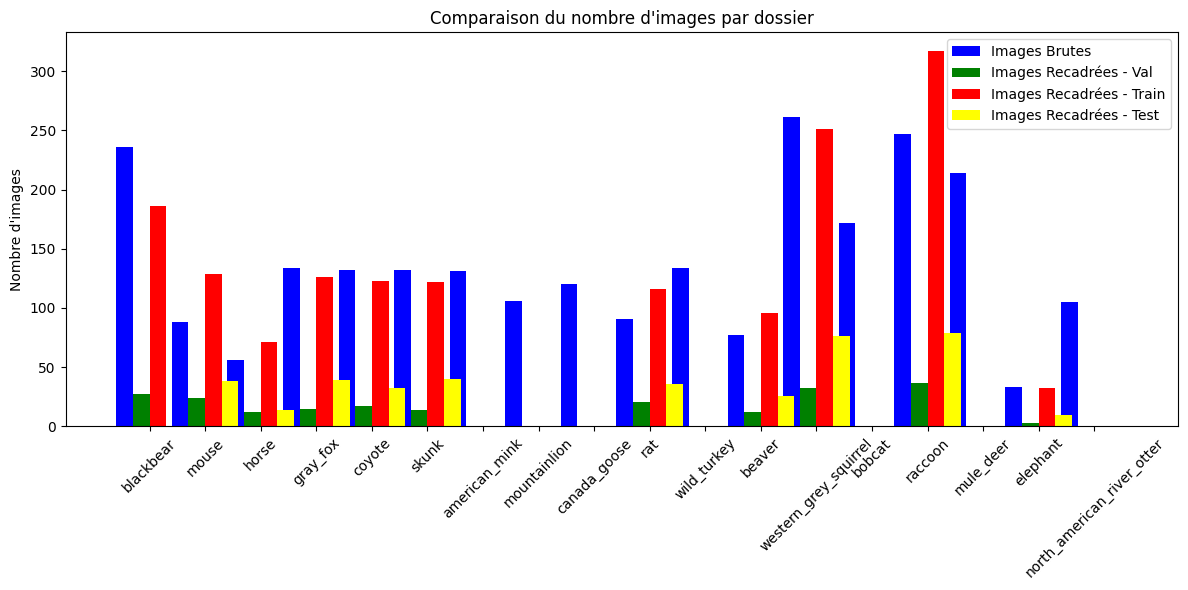

In [26]:
# Définition des chemins des datasets
raw_imgs = "data/OpenAnimalTracks/raw_imgs"
cropped_imgs_val = "data/OpenAnimalTracks/cropped_imgs/val"
cropped_imgs_train = "data/OpenAnimalTracks/cropped_imgs/train"
cropped_imgs_test = "data/OpenAnimalTracks/cropped_imgs/test"

# Fonction pour récupérer les infos des images d'un dossier (en gérant les dossiers absents)
def get_image_info(folder_path):
    if not os.path.exists(folder_path):  # 📌 Vérifie si le dossier existe
        return 0, None, None  # ⚠️ Si absent → 0 images et tailles nulles

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    num_images = len(image_files)

    if num_images == 0:
        return num_images, None, None  # Aucun fichier image

    widths, heights = [], []

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        try:
            with Image.open(img_path) as img:
                widths.append(img.width)
                heights.append(img.height)
        except Exception as e:
            print(f"Erreur avec l'image {img_file}: {e}")

    avg_width = sum(widths) / len(widths) if widths else None
    avg_height = sum(heights) / len(heights) if heights else None

    return num_images, avg_width, avg_height

# Listes pour stocker les infos
image_data_raw = []
image_data_cropped_val = []
image_data_cropped_train = []
image_data_cropped_test = []

# Parcourir chaque dossier et extraire les infos
for folder in df_all_animals["Nom du dossier"]:
    # 📂 Images brutes
    folder_path_raw = os.path.join(raw_imgs, folder)
    num_images_raw, avg_width_raw, avg_height_raw = get_image_info(folder_path_raw)
    image_data_raw.append([folder, num_images_raw, avg_width_raw, avg_height_raw])

    # ✂️ Images recadrées - validation
    folder_path_val = os.path.join(cropped_imgs_val, folder)
    num_images_val, avg_width_val, avg_height_val = get_image_info(folder_path_val)
    image_data_cropped_val.append([folder, num_images_val, avg_width_val, avg_height_val])

    # ✂️ Images recadrées - entraînement
    folder_path_train = os.path.join(cropped_imgs_train, folder)
    num_images_train, avg_width_train, avg_height_train = get_image_info(folder_path_train)
    image_data_cropped_train.append([folder, num_images_train, avg_width_train, avg_height_train])

    # ✂️ Images recadrées - entraînement
    folder_path_test = os.path.join(cropped_imgs_test, folder)
    num_images_test, avg_width_test, avg_height_test = get_image_info(folder_path_test)
    image_data_cropped_test.append([folder, num_images_test, avg_width_test, avg_height_test])

# Création des DataFrames
df_raw = pd.DataFrame(image_data_raw, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])
df_val = pd.DataFrame(image_data_cropped_val, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])
df_train = pd.DataFrame(image_data_cropped_train, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])
df_test = pd.DataFrame(image_data_cropped_test, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])

# Fusion des DataFrames pour comparaison
df_comparaison = df_raw.merge(df_val, on="Nom du dossier", suffixes=("_raw", "_val"))
df_comparaison = df_comparaison.merge(df_train, on="Nom du dossier", suffixes=("", "_train"))
df_comparaison = df_comparaison.merge(df_test, on="Nom du dossier", suffixes=("", "_test"))

# Renommer les colonnes pour plus de clarté
df_comparaison.rename(columns={
    "Nombre d'images": "Nombre d'images_train",
    "Largeur Moyenne": "Largeur Moyenne_train",
    "Hauteur Moyenne": "Hauteur Moyenne_train",
}, inplace=True)

# Affichage du DataFrame de comparaison
display(df_comparaison)

# 📊 Visualisation : Comparaison du nombre d'images par dossier
plt.figure(figsize=(12,6))

x_labels = df_comparaison["Nom du dossier"]
x_range = range(len(x_labels))

plt.bar(x_range, df_comparaison["Nombre d'images_raw"], width=0.3, label="Images Brutes", color='blue')
plt.bar([x + 0.3 for x in x_range], df_comparaison["Nombre d'images_val"], width=0.3, label="Images Recadrées - Val", color='green')
plt.bar([x + 0.6 for x in x_range], df_comparaison["Nombre d'images_train"], width=0.3, label="Images Recadrées - Train", color='red')
plt.bar([x + 0.9 for x in x_range], df_comparaison["Nombre d'images_test"], width=0.3, label="Images Recadrées - Test", color='yellow')

plt.xticks([x + 0.45 for x in x_range], x_labels, rotation=45)  # Centrage des labels
plt.ylabel("Nombre d'images")
plt.title("Comparaison du nombre d'images par dossier")
plt.legend()
plt.tight_layout()
plt.show()



In [15]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, monotonically_increasing_id, lit
import os
import base64

# 📌 Configuration de Spark avec JDBC MySQL
db_url = "jdbc:mysql://mysql-container:3306/wildlens?serverTimezone=UTC"
db_properties = {
    "user": "root",
    "password": "root",
    "driver": "com.mysql.cj.jdbc.Driver"
}

spark = SparkSession.builder \
    .appName("WildLens ETL - MSPR 24-25") \
    .config("spark.jars", "ETL/installation/mysql-connector-j-9.1.0.zip") \
    .getOrCreate()

# 📌 Chargement des métadonnées avec Spark
species_info_path = "data/csv/metadata.csv"
df_species = spark.read.option("header", True).option("sep", ",").csv(species_info_path)

# 📌 Nettoyage des localisations (gestion des zones)
df_species = df_species.withColumn("Localisation", split(col("Localisation"), ", "))

# 📌 Extraire les zones uniques
zones = df_species.selectExpr("explode(Localisation) as localisation").distinct()
zones = zones.withColumn("id_zone", monotonically_increasing_id())

# 📌 Insérer les zones dans `wildlens_d2_zone`
zones.write.jdbc(url=db_url, table="wildlens_d2_zone", mode="append", properties=db_properties)

# 📌 Récupération des ID des zones
zones_dict = {row["localisation"]: row["id_zone"] for row in zones.collect()}

# 📌 Associer chaque espèce à sa zone principale
def get_zone_id(localisation):
    return zones_dict.get(localisation[0], None) if localisation else None

get_zone_id_udf = spark.udf.register("get_zone_id", get_zone_id)
df_species = df_species.withColumn("id_zone", get_zone_id_udf(col("Localisation")))

# 📌 Sélection et insertion des espèces dans `wildlens_d3_especes`
df_species_filtered = df_species.select(
    col("Espèce").alias("espece"),
    col("Famille").alias("famille"),
    col("Nom latin").alias("nom_latin"),
    col("id_zone")
)

df_species_filtered.write.jdbc(url=db_url, table="wildlens_d3_especes", mode="append", properties=db_properties)

# 📌 Récupération des ID des espèces
species_df = spark.read.jdbc(url=db_url, table="wildlens_d3_especes", properties=db_properties)
species_dict = {row["espece"]: row["id_espece"] for row in species_df.collect()}

# 📌 Chargement des images et conversion en base64 pour MySQL
base_path = "data/OpenAnimalTracks/raw_imgs"
image_data = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue

    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        if img_file.lower().endswith(("png", "jpg", "jpeg")):
            try:
                with open(img_path, "rb") as image_file:
                    encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
                image_data.append((encoded_image,))
            except Exception as e:
                print(f"Erreur avec {img_path}: {e}")

# 📌 Création d'un DataFrame Spark avec les images
df_images = spark.createDataFrame(image_data, ["image_base64"])

# 📌 Envoi des images dans `wildlens_d1_images`
df_images.write.jdbc(url=db_url, table="wildlens_d1_images", mode="append", properties=db_properties)

# 📌 Récupération des ID des images
image_df = spark.read.jdbc(url=db_url, table="wildlens_d1_images", properties=db_properties)
image_ids = image_df.select("id_image").rdd.flatMap(lambda x: x).collect()

# 📌 Création de `wildlens_facts`
facts_data = []
for index, row in df_species.collect():
    espece = row["Espèce"]
    id_espece = species_dict.get(espece)
    id_image = image_ids[index] if index < len(image_ids) else None
    facts_data.append((id_espece, id_image, row["Description"], row["Population estimée"]))

df_facts = spark.createDataFrame(facts_data, ["id_espece", "id_image", "description", "population_estimee"])

# 📌 Insertion dans `wildlens_facts`
df_facts.write.jdbc(url=db_url, table="wildlens_facts", mode="append", properties=db_properties)

print("✅ Données insérées avec succès via Spark !")


25/02/21 16:13:00 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/02/21 16:13:00 INFO InMemoryFileIndex: It took 29 ms to list leaf files for 1 paths.
25/02/21 16:13:00 INFO InMemoryFileIndex: It took 2 ms to list leaf files for 1 paths.
25/02/21 16:13:02 INFO FileSourceStrategy: Pushed Filters: 
25/02/21 16:13:02 INFO FileSourceStrategy: Post-Scan Filters: (length(trim(value#0, None)) > 0)
25/02/21 16:13:02 INFO CodeGenerator: Code generated in 143.735863 ms
25/02/21 16:13:02 INFO MemoryStore: Block broadcast_0 stored as values in memory (estimated size 200.2 KiB, free 434.2 MiB)
25/02/21 16:13:02 INFO MemoryStore: Block broadcast_0_piece0 stored as bytes in memory (estimated size 34.5 KiB, free 434.2 MiB)
25/02/21 16:13:02 INFO BlockManagerInfo: Added broadcast_0_piece0 in memory on cedric-galaxy-book.home:41837 (size: 34.5 KiB, free: 434.4 MiB)
25/02/21 16:13:02 INFO SparkContext: Created broadcast 0 from csv at NativeMethodAc

Py4JJavaError: An error occurred while calling o129.jdbc.
: java.lang.ClassNotFoundException: com.mysql.cj.jdbc.Driver
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:445)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:593)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:526)
	at org.apache.spark.sql.execution.datasources.jdbc.DriverRegistry$.register(DriverRegistry.scala:46)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1(JDBCOptions.scala:103)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1$adapted(JDBCOptions.scala:103)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:103)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:254)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:258)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:47)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:48)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:869)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:391)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:364)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:251)
	at org.apache.spark.sql.DataFrameWriter.jdbc(DataFrameWriter.scala:766)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)


,Nom du dossier,Largeur Moyenne,Hauteur Moyenne,Poids Moyen (Ko),Taille Moyenne (Pixels)
0,blackbear,981.076271,853.016949,859.886222,8.949164e+05
1,mouse,768.750000,622.295455,483.855513,5.327778e+05
2,horse,1273.446429,1089.767857,1532.209891,2.179041e+06
3,gray_fox,1073.880597,819.679104,984.256333,9.940493e+05
4,coyote,961.363636,958.477273,850.411547,1.117847e+06
5,skunk,1098.969697,999.159091,1275.430893,1.169852e+06
6,american_mink,1147.305344,877.351145,1189.882589,1.216812e+06
7,mountainlion,901.198113,819.292453,900.470611,8.145616e+05
8,canada_goose,982.333333,749.841667,871.443376,9.140300e+05
9,rat,1140.615385,797.560440,1081.035306,9.927807e+05


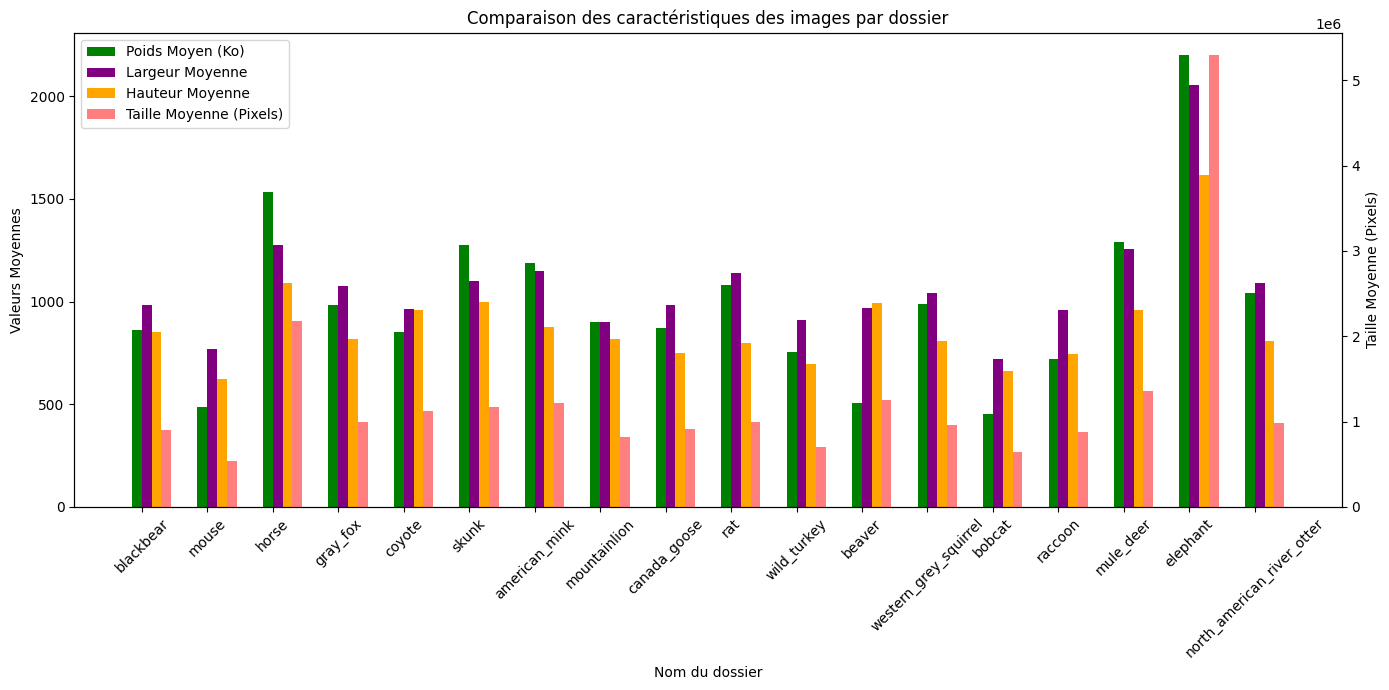

In [24]:
# 🔄 Fonction corrigée pour éviter le shadowing et enlever le "Nombre d'images"
def get_image_info_extended(folder_path):
    if not os.path.exists(folder_path):
        return None, None, 0, 0

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    widths_list, heights_list, sizes_kb_list, total_pixels_list = [], [], [], []

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        try:
            with Image.open(img_path) as img:
                img_width, img_height = img.size
                file_size_kb = os.path.getsize(img_path) / 1024
                widths_list.append(img_width)
                heights_list.append(img_height)
                sizes_kb_list.append(file_size_kb)
                total_pixels_list.append(img_width * img_height)
        except Exception as e:
            print(f"Erreur avec l'image {img_file}: {e}")

    avg_img_width = sum(widths_list) / len(widths_list) if widths_list else None
    avg_img_height = sum(heights_list) / len(heights_list) if heights_list else None
    avg_size_kb = sum(sizes_kb_list) / len(sizes_kb_list) if sizes_kb_list else None
    avg_total_pixels = sum(total_pixels_list) / len(total_pixels_list) if total_pixels_list else None

    return avg_img_width, avg_img_height, avg_size_kb, avg_total_pixels

# 📊 Stockage des données étendues sans "Nombre d'images"
image_data_extended = []

for folder in df_all_animals["Nom du dossier"]:
    folder_path_raw = os.path.join(raw_imgs, folder)
    avg_img_width, avg_img_height, avg_size_kb, avg_total_pixels = get_image_info_extended(folder_path_raw)
    image_data_extended.append([folder, avg_img_width, avg_img_height, avg_size_kb, avg_total_pixels])

# 🔗 Création DataFrame mis à jour
df_extended = pd.DataFrame(image_data_extended, columns=["Nom du dossier", "Largeur Moyenne", "Hauteur Moyenne", "Poids Moyen (Ko)", "Taille Moyenne (Pixels)"])

# 👁️‍🗨️ Affichage du DataFrame
display(df_extended)

# 📊 Nouveau graphique avec axe secondaire (sans Nombre d'images)
fig, ax1 = plt.subplots(figsize=(14,7))

x_labels = df_extended["Nom du dossier"]
x_range = range(len(x_labels))

# 📏 Axe principal pour Poids et Dimensions
ax1.bar([x + 0.15 for x in x_range], df_extended["Poids Moyen (Ko)"], width=0.15, label="Poids Moyen (Ko)", color='green')
ax1.bar([x + 0.3 for x in x_range], df_extended["Largeur Moyenne"], width=0.15, label="Largeur Moyenne", color='purple')
ax1.bar([x + 0.45 for x in x_range], df_extended["Hauteur Moyenne"], width=0.15, label="Hauteur Moyenne", color='orange')

ax1.set_xlabel("Nom du dossier")
ax1.set_ylabel("Valeurs Moyennes")
ax1.set_xticks([x + 0.225 for x in x_range])
ax1.set_xticklabels(x_labels, rotation=45)

# 📊 Axe secondaire pour la Taille Moyenne (Pixels)
ax2 = ax1.twinx()
ax2.bar([x + 0.6 for x in x_range], df_extended["Taille Moyenne (Pixels)"], width=0.15, label="Taille Moyenne (Pixels)", color='red', alpha=0.5)
ax2.set_ylabel("Taille Moyenne (Pixels)")

# 🔖 Combinaison des légendes des deux axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.title("Comparaison des caractéristiques des images par dossier")
plt.tight_layout()
plt.show()


In [ ]:
# Écrire les données dans la table MySQL
cleaned_df.write \
    .jdbc(url=db_url, table="Animaux", mode="overwrite", properties=db_properties)
